# Step 5.3: Machine Learning - Multiclass

Finally, we focus now on a multiclass SVM

In [1]:
# Import standard libraries
import os

# Import installed libraries
import numpy as np
import pandas as pd
import sklearn

from sklearn import preprocessing
from sklearn import svm
from sklearn.model_selection import GridSearchCV

In [2]:
# Let's mount the Google Drive, where we store files and models (if applicable, otherwise work
# locally)
try:
    from google.colab import drive
    drive.mount('/gdrive')
    core_path = "/gdrive/MyDrive/Colab/asteroid_taxonomy/"
except ModuleNotFoundError:
    core_path = ""

In [3]:
# Load the level 2 asteroid data
asteroids_df = pd.read_pickle(os.path.join(core_path, "data/lvl2/", "asteroids.pkl"))

In [4]:
# Allocate the spectra to one array and the classes to another one
asteroids_X = np.array([k["Reflectance_norm550nm"].tolist() for k in asteroids_df["SpectrumDF"]])
asteroids_y = np.array(asteroids_df["Main_Group"].to_list())

In [11]:
# In this example we create a single test-training split with a ratio of 0.8 / 0.2
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)

# Create a simple, single train / test split
for train_index, test_index in sss.split(asteroids_X, asteroids_y):
    
    X_train, X_test = asteroids_X[train_index], asteroids_X[test_index]
    y_train, y_test = asteroids_y[train_index], asteroids_y[test_index]

# Compute class weightnings
weight_dict = {}
for ast_type in np.unique(y_train):
    weight_dict[ast_type] = int(1.0 / (len(y_train[y_train == ast_type]) / (len(y_train))))

In [41]:
from sklearn.metrics import make_scorer, f1_score

# Perform now a GridSearch with the following parameter range and kernels
param_grid = [
  {'C': np.logspace(0, 3, 25), 'kernel': ['linear']},
  {'C': np.logspace(0, 3, 25), 'kernel': ['rbf']},
 ]

# Set the SVM classifier
svc = svm.SVC(class_weight=weight_dict)

# Instantiate the StandardScaler (mean 0, standard deviation 1) and use the training data to fit
# the scaler
scaler = preprocessing.StandardScaler().fit(X_train)

# Transform now the training data
X_train_scaled = scaler.transform(X_train)

# Set the GridSearch. Use the f1 "weighted" score in a maker_scorer function. And ...
wclf = GridSearchCV(svc, param_grid, scoring=make_scorer(f1_score, average="weighted"), verbose=3, cv=5)

# ... perform the training!
wclf.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5] END ...........................C=100, kernel=linear; total time=   3.8s
[CV 2/5] END ...........................C=100, kernel=linear; total time=   3.7s
[CV 3/5] END ...........................C=100, kernel=linear; total time=   3.0s
[CV 4/5] END ...........................C=100, kernel=linear; total time=   2.8s
[CV 5/5] END ...........................C=100, kernel=linear; total time=   5.0s
[CV 1/5] END ..............................C=100, kernel=rbf; total time=   0.0s
[CV 2/5] END ..............................C=100, kernel=rbf; total time=   0.0s
[CV 3/5] END ..............................C=100, kernel=rbf; total time=   0.0s
[CV 4/5] END ..............................C=100, kernel=rbf; total time=   0.0s
[CV 5/5] END ..............................C=100, kernel=rbf; total time=   0.0s


GridSearchCV(cv=5,
             estimator=SVC(class_weight={'C': 3, 'Other': 8, 'S': 2, 'X': 5}),
             param_grid=[{'C': [100], 'kernel': ['linear']},
                         {'C': [100], 'kernel': ['rbf']}],
             scoring=make_scorer(f1_score, average=weighted), verbose=3)

In [42]:
# Let's print some SVM results
final_clf = wclf.best_estimator_

print(f"Kernel with the best result: {final_clf.kernel}")
print(f"SVM information: {final_clf}")

Kernel with the best result: rbf
SVM information: SVC(C=100, class_weight={'C': 3, 'Other': 8, 'S': 2, 'X': 5})


In [20]:
# Scale the testing data ...
X_test_scaled = scaler.transform(X_test)

# ... and perform a predicition
y_test_pred = final_clf.predict(X_test_scaled)

In [43]:
# Import the confusion matrix and perform the computation
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_test_pred, labels=["C", "S", "X", "Other"])

print(conf_mat)

[[ 75   0   4   0]
 [  0 107   0   3]
 [  1   0  46   1]
 [  0   5   0  26]]


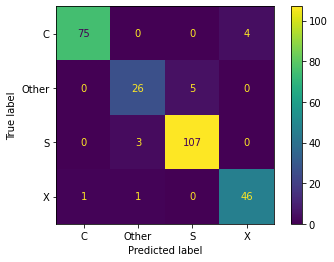

In [44]:
# For a better visualisation, let's plot the confusion matrix
import matplotlib.pyplot as plt  
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(final_clf, X_test_scaled, y_test, values_format='d')  
plt.show()  

In [30]:
# A combined score
f1_score = round(sklearn.metrics.f1_score(y_test, y_test_pred, average="weighted"), 3)
print(f"F1 Score: {f1_score}")

F1 Score: 0.948
